Computer Vision : Assignment - 2

Krishna Praneet Mulukutla

2020113010

# Part 1: SIFT-BoVW-SVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import wandb
from einops import rearrange

In [2]:
# random seed
np.random.seed(42)
torch.manual_seed(42)

Number of train samples :  60000
Number of train samples :  10000


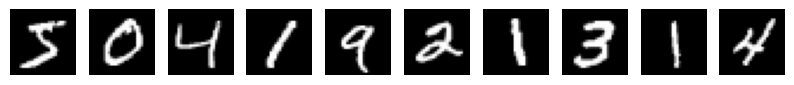

In [3]:
'''Load the MNIST dataset'''
mnist_train = datasets.MNIST(root='./datasets', train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root='./datasets', train=False, download=True, transform=None)
print("Number of train samples : " , len(mnist_train))
print("Number of train samples : " , len(mnist_test))

# display the first 10 images
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(mnist_train[i][0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [4]:
'''SIFT feature extraction for the train set'''
# # detect and compute SIFT features for all train images
# key_point_list = []         # list of key points for each image
# descriptor_list = []        # list of descriptors for each image
# train_features = []         # list of all descriptors
# train_labels = []           # list of labels for each image (one label per image)

# # classify test images
# key_point_list_test = []         # list of key points for each image
# descriptor_list_test = []        # list of descriptors for each image
# test_features = []               # list of all descriptors
# test_labels = []                 # list of labels for each image (one label per image)

def extract_sift_features(nfeatures=0, sigma=1.6):
    sift = cv.SIFT_create(nfeatures=nfeatures, sigma=sigma)

    global key_point_list, descriptor_list, train_features, train_labels
    global key_point_list_test, descriptor_list_test, test_features, test_labels

    key_point_list = []         # list of key points for each image
    descriptor_list = []        # list of descriptors for each image
    train_features = []         # list of all descriptors
    train_labels = []           # list of labels for each image (one label per image)

    key_point_list_test = []         # list of key points for each image
    descriptor_list_test = []        # list of descriptors for each image
    test_features = []               # list of all descriptors
    test_labels = []                 # list of labels for each image (one label per image)


    for i in range(len(mnist_train)):
        img = np.array(mnist_train[i][0])
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            key_point_list.append(kp)
            descriptor_list.append(des)
            train_labels.append(mnist_train[i][1])
            train_features.extend(des)
        else:
            key_point_list.append([])
            descriptor_list.append([])
            train_labels.append(mnist_train[i][1])
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)

    print("Number of elements in key_point_list : ", len(key_point_list))
    print("Number of elements in descriptor_list : ", len(descriptor_list))
    print("Number of train features : ", train_features.shape)
    print("Number of train labels : ", train_labels.shape)
    print()


    '''SIFT feature extraction for the test set'''

    for i in range(len(mnist_test)):
        img = np.array(mnist_test[i][0])
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            key_point_list_test.append(kp)
            descriptor_list_test.append(des)
            test_labels.append(mnist_test[i][1])
            test_features.extend(des)
        else:
            key_point_list_test.append([])
            descriptor_list_test.append([])
            test_labels.append(mnist_test[i][1])
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)

    print("Number of elements in key_point_list : ", len(key_point_list_test))
    print("Number of elements in descriptor_list : ", len(descriptor_list_test))
    print("Number of test features : ", test_features.shape)
    print("Number of test labels : ", test_labels.shape)
    print()

In [5]:
def cluster_features(k, train_features):
    # use k means to cluster the features
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=4)
    kmeans.fit(train_features)
    print("Number of cluster centers : ", kmeans.cluster_centers_.shape[0])
    print("Dimesion of cluster centers : ", kmeans.cluster_centers_.shape[1])
    print()
    return kmeans

def make_histograms(descriptor_list, kmeans, k):
    # make k sized histogram for each image
    histograms = []
    for i in range(len(descriptor_list)):
        if len(descriptor_list[i]) == 0:
            histograms.append(np.zeros(k))
        else:
            labels = kmeans.predict(descriptor_list[i])
            hist, _ = np.histogram(labels, bins=k, range=(0, k))
            histograms.append(hist)
    histograms = np.array(histograms)
    print("Shape of train histograms : ", histograms.shape)
    print()
    return histograms

def train_SVM(train_histograms, train_labels, c=1.0):
    # train a linear SVM for 10-way classification using the histograms
    svm = LinearSVC(random_state=42, max_iter=10000)
    svm.fit(train_histograms, train_labels)
    return svm

def test_SVM(svm, histograms, labels, testOrTrain='Test'):
    acc = accuracy_score(labels, svm.predict(histograms))
    print(testOrTrain, "Accuracy : ", acc)
    print('-------------------------------------')
    return acc

Number of elements in key_point_list :  60000
Number of elements in descriptor_list :  60000
Number of train features :  (469496, 128)
Number of train labels :  (60000,)

Number of elements in key_point_list :  10000
Number of elements in descriptor_list :  10000
Number of test features :  (78515, 128)
Number of test labels :  (10000,)



k =  2
Number of cluster centers :  2
Dimesion of cluster centers :  128

Shape of train histograms :  (60000, 2)



/home/prani/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Train Accuracy :  0.21541666666666667
-------------------------------------
Shape of train histograms :  (10000, 2)

Test Accuracy :  0.2188
-------------------------------------


k =  4
Number of cluster centers :  4
Dimesion of cluster centers :  128

Shape of train histograms :  (60000, 4)

Train Accuracy :  0.3070333333333333
-------------------------------------
Shape of train histograms :  (10000, 4)

Test Accuracy :  0.3149
-------------------------------------


k =  10
Number of cluster centers :  10
Dimesion of cluster centers :  128

Shape of train histograms :  (60000, 10)

Train Accuracy :  0.39703333333333335
-------------------------------------
Shape of train histograms :  (10000, 10)

Test Accuracy :  0.4006
-------------------------------------


k =  50
Number of cluster centers :  50
Dimesion of cluster centers :  128

Shape of train histograms :  (60000, 50)

Train Accuracy :  0.6462833333333333
-------------------------------------
Shape of train histograms :  (1

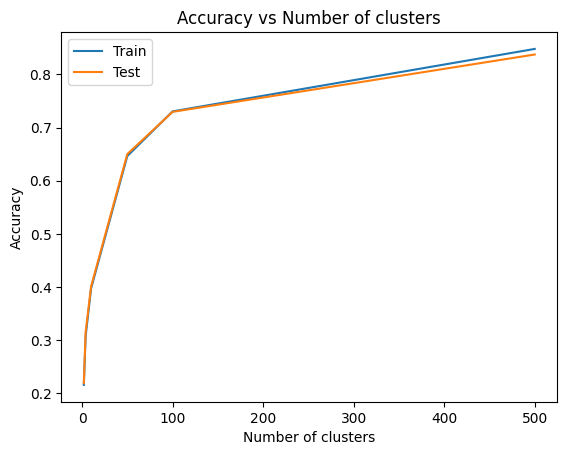

In [6]:
'''Training and testing a linear SVM using histogram made using SIFT features'''

k_vals = [2, 4, 10, 50, 100, 500]
accuracies = np.zeros((len(k_vals), 2))

extract_sift_features()

for k in k_vals:
    print("\n\nk = ", k)
    
    kmeans = cluster_features(k, train_features)
    train_histograms = make_histograms(descriptor_list, kmeans, k)
    svm = train_SVM(train_histograms, train_labels)
    accuracies[k_vals.index(k), 0] = test_SVM(svm, train_histograms, train_labels, 'Train')

    # test the SVM on the test set
    test_histograms = make_histograms(descriptor_list_test, kmeans, k)
    accuracies[k_vals.index(k), 1] = test_SVM(svm, test_histograms, test_labels, 'Test')

plt.plot(k_vals, accuracies[:, 0], label='Train')
plt.plot(k_vals, accuracies[:, 1], label='Test')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of clusters')
plt.legend()
plt.show()

### 1.2
As we can see from the graph above, for the cluster numbers [2,4,10,50,100,500], we see an increase in the accuracy of the model as the number of clusters increases. Moreover, we also see that the accuracy seems to reach a saturation point. That is, the increase in the accuracy is not as significant as the number of clusters increases for large values of clusters. This can happen when the number of clusters is roughly equal to the different types of descriptors that can be extracted.

In [7]:
part1_Hyp = []  # each element is a list containing [nfeatures, sigma, c]
part1_Hyp.append([0, 1.6, 1.0])
part1_Hyp.append([0, 1.6, 0.1])
part1_Hyp.append([0, 1.6, 10.0])
part1_Hyp.append([0, 0.8, 1.0])
part1_Hyp.append([0, 3.2, 1.0])
part1_Hyp.append([100, 1.6, 1.0])



nfeatures =  0  sigma =  1.6  c =  1.0
Number of elements in key_point_list :  60000
Number of elements in descriptor_list :  60000
Number of train features :  (469496, 128)
Number of train labels :  (60000,)

Number of elements in key_point_list :  10000
Number of elements in descriptor_list :  10000
Number of test features :  (78515, 128)
Number of test labels :  (10000,)

Number of cluster centers :  100
Dimesion of cluster centers :  128

Shape of train histograms :  (60000, 100)

Train Accuracy :  0.7305666666666667
-------------------------------------
Shape of train histograms :  (10000, 100)

Test Accuracy :  0.7295
-------------------------------------


nfeatures =  0  sigma =  1.6  c =  0.1
Number of elements in key_point_list :  60000
Number of elements in descriptor_list :  60000
Number of train features :  (469496, 128)
Number of train labels :  (60000,)

Number of elements in key_point_list :  10000
Number of elements in descriptor_list :  10000
Number of test features

/home/prani/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Train Accuracy :  0.7813
-------------------------------------
Shape of train histograms :  (10000, 100)

Test Accuracy :  0.7799
-------------------------------------


nfeatures =  0  sigma =  3.2  c =  1.0
Number of elements in key_point_list :  60000
Number of elements in descriptor_list :  60000
Number of train features :  (81460, 128)
Number of train labels :  (60000,)

Number of elements in key_point_list :  10000
Number of elements in descriptor_list :  10000
Number of test features :  (13944, 128)
Number of test labels :  (10000,)

Number of cluster centers :  100
Dimesion of cluster centers :  128

Shape of train histograms :  (60000, 100)

Train Accuracy :  0.4821166666666667
-------------------------------------
Shape of train histograms :  (10000, 100)

Test Accuracy :  0.4906
-------------------------------------


nfeatures =  100  sigma =  1.6  c =  1.0
Number of elements in key_point_list :  60000
Number of elements in descriptor_list :  60000
Number of train features 

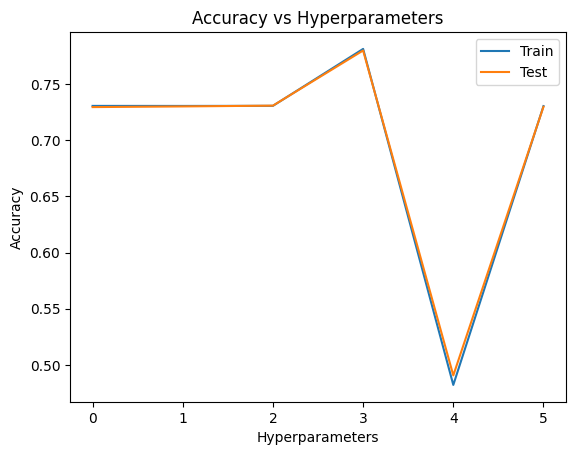

In [8]:
accs = np.zeros((len(part1_Hyp), 2))

for hyp in part1_Hyp:
    print("\n\nnfeatures = ", hyp[0], " sigma = ", hyp[1], " c = ", hyp[2])
    extract_sift_features(hyp[0], hyp[1])
    kmeans = cluster_features(100, train_features)
    train_histograms = make_histograms(descriptor_list, kmeans, 100)
    svm = train_SVM(train_histograms, train_labels, hyp[2])
    accs[part1_Hyp.index(hyp), 0] = test_SVM(svm, train_histograms, train_labels, 'Train')

    test_histograms = make_histograms(descriptor_list_test, kmeans, 100)
    accs[part1_Hyp.index(hyp), 1] = test_SVM(svm, test_histograms, test_labels, 'Test')

plt.plot(range(len(part1_Hyp)), accs[:, 0], label='Train')
plt.plot(range(len(part1_Hyp)), accs[:, 1], label='Test')
plt.xlabel('Hyperparameters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Hyperparameters')
plt.legend()
plt.show()


### 1.3
The features I chose to vary are nfeatures and sigma in sift.create() and c in SVM. nfeatures gives the number of best features to retain. Sigma is the standard deviation of the Gaussian used in the lowest octave in SIFT. Smaller sigma gives more features. Smaller sigma is useful for images taken with weak camera. c is the regularization parameter in SVM. Smaller c gives more regularization. Smaller c is useful when the data is noisy.

As can be seen, the first three sets of values give very similar accuracies. So this implies that the value of c is not very important in this case. Also note that the last set also gives a simialr accuracy. This means that the nfeatures is not very important either. 

But we see an increase in accuracy for a lower value of sigma. This means that the value of sigma is important in this case. This is because a lower value of sigma gives more features and hence more information to the model. This is why the accuracy is higher for a lower value of sigma. Conversely, a higher value of sigma gives less features and hence less information to the model. This is why the accuracy is lower for a higher value of sigma.

# Part 2: CNNs and Transformers

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

isSubset = True
num_samples_per_class = 600

# get the dataset and transform the images to tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./datasets', train=False, download=True, transform=transform)

def split_dataset(mnist_train, num_samples_per_class=1000):
    # Split the dataset into separate subsets for each class
    class_subsets = [[] for _ in range(10)]
    for i in range(len(mnist_train)):
        image, label = mnist_train[i]
        class_subsets[label].append(i)

    # Take a fixed number of samples from each class subset
    balanced_subset_indices = []
    for class_subset in class_subsets:
        selected_indices = np.random.choice(class_subset, size=num_samples_per_class, replace=False)
        balanced_subset_indices.extend(selected_indices)

    # Create a Subset of the MNIST dataset with the balanced subset indices
    balanced_subset = torch.utils.data.Subset(mnist_train, balanced_subset_indices)
    return balanced_subset

if isSubset:
    mnist_train = split_dataset(mnist_train, num_samples_per_class)

Using device: cuda


In [10]:
'''Models'''
# LeNet
class LeNet(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        
        # feature extraction
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, padding=2),    # 28x28@1 -> 28x28@6
            torch.nn.ReLU(),                                    # activation function
            torch.nn.MaxPool2d(kernel_size=2),                  # 28x28@6 -> 14x14@6
            torch.nn.Conv2d(6, 16, kernel_size=5),              # 14x14@6 -> 10x10@16
            torch.nn.ReLU(),                                    # activation function
            torch.nn.MaxPool2d(kernel_size=2)                   # 10x10@16 -> 5x5@16
        )

        # classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),                       # 16*5*5 -> 120
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Linear(120, 84),                           # 120 -> 84
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Linear(84, num_classes)                    # 84 -> 10
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        probs = self.classifier(x)
        probs = torch.nn.functional.softmax(probs, dim=-1)
        return probs

# LeNet with double the number of convolutional layers
class LeNet_Double(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet_Double, self).__init__()
        
        # feature extraction
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, padding=2),    # 28x28@1 -> 28x28@6
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Conv2d(6, 8, kernel_size=5, padding=2),    # 28x28@6 -> 28x28@8
            torch.nn.ReLU(),                                    # activation function
            torch.nn.MaxPool2d(kernel_size=2),                  # 28x28@8 -> 14x14@8
            torch.nn.Conv2d(8, 12, kernel_size=5, padding=2),   # 14x14@8 -> 14x14@12
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Conv2d(12, 16, kernel_size=5),             # 14x14@12 -> 10x10@16
            torch.nn.ReLU(),                                    # activation function
            torch.nn.MaxPool2d(kernel_size=2)                   # 10x10@16 -> 5x5@16
        )

        # classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),                       # 16*5*5 -> 120
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Linear(120, 84),                           # 120 -> 84
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Linear(84, num_classes)                    # 84 -> 10
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        probs = self.classifier(x)
        probs = torch.nn.functional.softmax(probs, dim=-1)
        return probs

# Basice ViT model with 2 transformer layers
class TransformerModel(torch.nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.patch_size = 7
        patch_dim = self.patch_size * self.patch_size
        num_patches = 16
        self.emb_size = 128

        self.patch_embed = torch.nn.Linear(patch_dim, self.emb_size)
        self.position_embed = torch.nn.Parameter(torch.randn(1, num_patches + 1, self.emb_size))
        self.cls_token = torch.nn.Parameter(torch.randn(1, 1, self.emb_size))
        self.transfromer_encoder_layer = torch.nn.TransformerEncoderLayer(d_model=self.emb_size, nhead=8, batch_first=True)
        self.transfromer_encoder = torch.nn.TransformerEncoder(self.transfromer_encoder_layer, num_layers=2)

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.emb_size, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 10),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        # x is of shape (batch_size, 1, 28, 28)
        batch_size, _, _, _ = x.shape
        # convert to (batch_size, 16, 7, 7) ie 16 patches of size 7x7
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        
        # get embeddings for the patches
        x = self.patch_embed(x)

        # adding the classification token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # adding position embedding
        x += self.position_embed
        x = self.transfromer_encoder(x)

        x = x[:, 0, :]
        probs = self.classifier(x)
        return probs

In [11]:
# Data loaders
def use_data_loader(config):
    train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=config.batch_size, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=config.batch_size, shuffle=False, num_workers=4)
    return train_loader, test_loader

In [12]:
def train_and_test_model(model, train_loader, test_loader, criterion, optimizer, config):
    # Training
    for epoch in range(config.epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # forward and backward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            # parameter update
            optimizer.step()
            # loss calculation
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)

        # calculate average loss and accuracy
        train_loss = train_loss / len(mnist_train)
        train_acc = train_acc.double() / len(mnist_train)
        print(f'Epoch {epoch+1}/{config.epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        # Testing
        model.eval()
        test_loss = 0.0
        test_acc = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data)

        # calculate average loss and accuracy
        test_loss = test_loss / len(mnist_test)
        test_acc = test_acc.double() / len(mnist_test)
        print(f'Epoch {epoch+1}/{config.epochs}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        # Log the loss and accuracy values at the end of each epoch
        wandb.log({
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Train Accuracy": train_acc,
            "Test Loss": test_loss,
            "Test Accuracy": test_acc
        })

    # Finish the run
    wandb.finish()

In [13]:
# 8 different hyperparameter settings
hyp_set = []
hyp_set.append(dict(learning_rate=0.01, batch_size=64, epochs=10, optimizer='adam', random_seed=42, name='hyp1'))
hyp_set.append(dict(learning_rate=0.01, batch_size=64, epochs=10, optimizer='sgd', random_seed=42, name='hyp2'))
hyp_set.append(dict(learning_rate=0.01, batch_size=128, epochs=10, optimizer='adam', random_seed=42, name='hyp3'))
hyp_set.append(dict(learning_rate=0.01, batch_size=128, epochs=10, optimizer='sgd', random_seed=42, name='hyp4'))
hyp_set.append(dict(learning_rate=0.001, batch_size=64, epochs=10, optimizer='adam', random_seed=42, name='hyp5'))
hyp_set.append(dict(learning_rate=0.001, batch_size=64, epochs=10, optimizer='sgd', random_seed=42, name='hyp6'))
hyp_set.append(dict(learning_rate=0.001, batch_size=128, epochs=10, optimizer='adam', random_seed=42, name='hyp7'))
hyp_set.append(dict(learning_rate=0.001, batch_size=128, epochs=10, optimizer='sgd', random_seed=42, name='hyp8'))

trans_config = dict(learning_rate=0.0001, batch_size=128, epochs=15, optimizer='adam', random_seed=42, name='ViT')

In [14]:
# initialize the model

# LeNet model
model = LeNet().to(device)

# uncomment the following 2 lines to use the double LeNet model
# model_double = LeNet_Double().to(device)
# model = model_double

# uncomment the following 2 lines to use the ViT model and change the config to trans_config
trnsfmr_model = TransformerModel().to(device)
model = trnsfmr_model

In [15]:
# Hyperparameters
config = trans_config

############ imp : change the config to the desired hyperparameters based on the model you are using ############

# Initialize a new wandb run
wandb.init(project="cv-assi2", config=config, name=config['name'])

# Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
if config.optimizer == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mulukutla-p (mkp). Use `wandb login --relogin` to force relogin


In [16]:
# load data and train and test the model
train_loader, test_loader = use_data_loader(config)
train_and_test_model(model, train_loader, test_loader, criterion, optimizer, config)

Epoch 1/15, Train Loss: 2.2990, Train Acc: 0.1342
Epoch 1/15, Test Loss: 2.2723, Test Acc: 0.2536
Epoch 2/15, Train Loss: 2.1580, Train Acc: 0.4448
Epoch 2/15, Test Loss: 1.9654, Test Acc: 0.6473
Epoch 3/15, Train Loss: 1.9041, Train Acc: 0.6728
Epoch 3/15, Test Loss: 1.7770, Test Acc: 0.7461
Epoch 4/15, Train Loss: 1.7595, Train Acc: 0.7717
Epoch 4/15, Test Loss: 1.6764, Test Acc: 0.8229
Epoch 5/15, Train Loss: 1.6974, Train Acc: 0.8005
Epoch 5/15, Test Loss: 1.6461, Test Acc: 0.8332
Epoch 6/15, Train Loss: 1.6680, Train Acc: 0.8200
Epoch 6/15, Test Loss: 1.6109, Test Acc: 0.8846
Epoch 7/15, Train Loss: 1.6202, Train Acc: 0.8790
Epoch 7/15, Test Loss: 1.5778, Test Acc: 0.9060
Epoch 8/15, Train Loss: 1.5963, Train Acc: 0.8902
Epoch 8/15, Test Loss: 1.5638, Test Acc: 0.9138
Epoch 9/15, Train Loss: 1.5806, Train Acc: 0.9017
Epoch 9/15, Test Loss: 1.5564, Test Acc: 0.9158
Epoch 10/15, Train Loss: 1.5675, Train Acc: 0.9085
Epoch 10/15, Test Loss: 1.5463, Test Acc: 0.9241
Epoch 11/15, Train

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Test Accuracy,▁▅▆▇▇▇█████████
Test Loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▆▇▇▇█████████
Train Loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁
Epoch,14
Test Accuracy,0.9368
Test Loss,1.52822
Train Accuracy,0.92917
Train Loss,1.54152


### Q 2.2

Here is the link to the WandB Report on this. [WandB Report 2.2](https://wandb.ai/mkp/cv-assi2/reports/CNN-Hyperparameter-Comparison--Vmlldzo3MDc4MTA5?accessToken=5ewsjxvzmhlv7rdao4xbjova1irk25agn9ghx107xyrfmd7bh117ydnq7tt7vsjz)

As we can see clearly, the combination of optimizer with the learning rate is extremely important. More so in the case of SGD than Adam optimizer. Whenever SGD is paired with a learning rate of 0.001, the accuracy is very low. This is because the learning rate is too low for the optimizer to learn. Conversely, whenever Adam is paired with a learning rate of 0.01, it is a comparatively lower accuracy than when learning rate is 0.001. This is because the learning rate is too high for the optimizer to learn.

Other than this, a change in batch size from 64 to 128 does not seem to have a significant impact on the accuracy. But more radical changes might indeed have an impact. Noticed that faster convergence is observed with a higher batch size. This is because the model is updated less frequently and hence the convergence is faster.

So I would say that the learning rate is the most important hyperparameter in this case, when paired with a particular optimizer.


### Q 2.3

The best CNN model gives an accuracy of 0.98 on the test set. This is far better than the best accuracy of 0.85 achieved by the best BoVW model (500 clusters) using SIFT features. 

Also note that using GPU, the CNN model takes only 1 minute to train, whereas the BoVW model takes 3 minutes to train for 100 clusters. This is a significant difference in training time and CNN is better in this aspect also.

With perfect hyperparameters, SIFT-BoVW might approach the accuracy of CNN at high number of clusters, but CNN is still better in terms of training time and ease of use. Generally, CNN performs better because it is more parametrized than SIft-BoVW.

### Q 2.4

Link to the WandB Report on this. [WandB Report 2.4](https://wandb.ai/mkp/cv-assi2/reports/Doubling-Convolutional-Layers--Vmlldzo3MDc5MDI2?accessToken=qn68veo76mc4pd1cj7ge95184sf9kkt65x87oj7mq9jfozg9iz1zud7c15x2ueb0)

As we can see, the accuracy for double the convolutional layers is very similar to the accuracy for the original model. This is because the original model is already complex enough to capture the features in the data. Adding more convolutional layers does not add much to the model. This is why the accuracy is similar to the original model.

It might be a different case if the dataset were more complex and had more features. In that case, the original model might not be complex enough to capture the features in the data. In that case, adding more convolutional layers might increase the accuracy of the model.

### Q 2.5

Link to the WandB Report on this. [WandB Report 2.5](https://api.wandb.ai/links/mkp/7ry00jzd)

As we can see from the accuracies, the 0.6K has accuracy of 0.812, 1.8K has an accuracy of 0.94, 6.0K has accuracy of 0.96, 18K has accuracy of 0.97, whereas the accuracy for 60K was 0.98. This shows that the increase in accuracy is not as significant after a few thousand images. This is also like a saturation point, where increasing the training sample size does not increase the accuracy significantly. This is because the model has already seen enough data to learn the features in the data. This is why the accuracy is not increasing significantly after a few thousand images.

### Q 2.6

Link to the WandB Report on this. [WandB Report 2.6 ViT vs LeNet](https://wandb.ai/mkp/cv-assi2/reports/ViT-vs-LeNet--Vmlldzo3MDg3Njg5?accessToken=5c3udegnl6rvn87nvc57q98cwdwgbpyybeit1elcg0l58s86fc65rjqp4rg8dhxp) and [WandB Report 2.6 ViT_60K vs ViT_6K](https://wandb.ai/mkp/cv-assi2/reports/ViT-with-subset-of-MNIST--Vmlldzo3MDg3ODY4?accessToken=v7d6v0evx8nd2xvnnud8pel29dnwkotki1spz00wkdyn1fwsqctsga9abh1eoui3)

From the first report, we see how this ViT model compares to LeNET (CNN). Note that I ran ViT for 15 epochs since the convergence was not complete at 10 epochs. We see that the accuracy of ViT is 0.97, very close to the accuracy of LeNet which is 0.98. This shows that ViT is a very good model for image classification, and is comparable to CNN. But note that ViT took 2 minutes to train, whereas LeNet took 1 minute to train. This is a somewhat significant difference in training time.

So we see that ViT is a fairly good model for image classification.

From the second report, we see that ViT_60K has an accuracy of 0.97, whereas, ViT_6K has an accuracy of 0.93. In contrast, LeNet Model with 6K images gave an accuracy of 0.96. 

This shows that ViT requires more data to train than LeNet. There is still some difference in accuracy between ViT_60K and and ViT_6K, but the difference is not much between LeNet_6K and LeNet_60K. This could be due to multiple reasons, like the choice of patch size, the number of layers, embeddings, etc. 